In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from modules import analysis

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

from modules import utils

In [2]:
# plotting styles
# color pallette
colors = ['#3185FC', '#FFBA08', '#7F7F7F', '#D00000', '#E28826', '#8FE388', '#1B998B', '#00CDC8', '#335BA3', '#9B68CE', '#46237A', 
          '#FF537C', '#FF9B85']
lc_colors = {
    'ENF': '#00CDC8',
    'EBF': '#1B998B',
    'DBF': '#8FE388',
    'MF': '#D5E002',
    'CRO': '#D00000',
    'WET': '#3185FC',
    'GRA': '#9B68CE',
    'SH': '#E28826',
    'SAV': '#FF9B85',
    'WAT': '#335BA3',
    'SNO': '#7F7F7F',
    'BAR': '#FFBA08',
    'REST': '#46237A'
}
sns.set_palette(sns.color_palette(colors))
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 12

In [3]:
# PFT mapping
pft_replacements = pd.DataFrame({
    'MODIS': np.arange(1, 18),
    'New': ['ENF', 'EBF', 'DNF', 'DBF', 'MF', 'SH', 'SH', 'SAV', 'SAV', 'GRA', 'WET', 'CRO', 'URB', 'CVM', 'SNO', 'BSV', 'WAT'],
    'Site': ['ENF', 'EBF', 'DNF', 'DBF', 'MF', 'CSH', 'OSH', 'WSA', 'SAV', 'GRA', 'WET', 'CRO', 'URB', 'CVM', 'SNO', 'BSV', 'WAT'],   
})

## Pre-process data
Loads meta data and explanatory variables, combines data frames to geodataframe, removes outliers and low-quality values
Only execute if new data created, otherwise load CSV below

In [4]:
# pre-process meta data
# load site meta data
meta_raw = pd.read_csv('data/ec/site_summary_v0_2.csv')

# create multiindex with SITE_ID and Date
meta = meta_raw.set_index('SITE_ID', drop=True)
meta['IGBP'] = meta['IGBP'].replace(pft_replacements.set_index('Site')['New'].to_dict())

# manually correct missing IGBP
meta.loc['DE-Hte', 'IGBP'] = 'WET'
meta.loc['RU-Fy2', 'IGBP'] = 'ENF'

#clean
meta['Dataset'] = meta['dataset'].replace({'ameriflux': 'Ameriflux', 'fluxnet': 'Fluxnet'})
meta['Climate'] = meta['koppen_main'].replace({1: 'tropical', 2: 'dry', 3: 'temperate', 4: 'continental', 5: 'polar'})

meta = meta.drop(['dataset'], axis=1)
meta.to_csv('data/ec/sites_meta_v1.csv')
meta

,start_year,end_year,path,dup,IGBP,LOCATION_ELEV,LOCATION_LAT,LOCATION_LONG,SITE_NAME,koppen_sub,koppen_main,koppen_name,koppen_main_name,Dataset,Climate
SITE_ID,,,,,,,,,,,,,,,
CA-Ca1,1996,2010,/Users/yanghuikang/Documents/Work/Research/Pho...,False,ENF,300.0,49.86730,-125.333600,British Columbia - 1949 Douglas-fir stand,15.0,3,Cfb,Temperate,Ameriflux,temperate
CA-Ca2,1999,2010,/Users/yanghuikang/Documents/Work/Research/Pho...,False,ENF,300.0,49.87050,-125.290900,British Columbia - Clearcut Douglas-fir stand ...,9.0,3,Csb,Temperate,Ameriflux,temperate
CA-Ca3,2001,2010,/Users/yanghuikang/Documents/Work/Research/Pho...,False,ENF,NaN,49.53460,-124.900400,British Columbia - Pole sapling Douglas-fir stand,9.0,3,Csb,Temperate,Ameriflux,temperate
CA-Cbo,1994,2014,/Users/yanghuikang/Documents/Work/Research/Pho...,False,DBF,120.0,44.31670,-79.933300,"Ontario - Mixed Deciduous, Borden Forest Site",26.0,4,Dfb,Cold,Ameriflux,continental
CA-Gro,2003,2014,/Users/yanghuikang/Documents/Work/Research/Pho...,True,MF,340.0,48.21670,-82.155600,"Ontario - Groundhog River, Boreal Mixedwood Fo...",26.0,4,Dfb,Cold,Ameriflux,continental
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE-Htm,2015,2020,/Users/yanghuikang/Documents/Work/Research/Pho...,True,ENF,NaN,56.09763,13.418970,Hyltemossa,26.0,4,Dfb,Cold,ICOS2020,continental
SE-Lnn,2014,2018,/Users/yanghuikang/Documents/Work/Research/Pho...,False,NaN,71.0,58.34063,13.101770,Lanna,26.0,4,Dfb,Cold,ICOS2018,continental
SE-Nor,2014,2020,/Users/yanghuikang/Documents/Work/Research/Pho...,True,ENF,NaN,60.08650,17.479504,Norunda,26.0,4,Dfb,Cold,ICOS2020,continental


In [5]:
# pre-process target and explanatory variables
# load data
data_raw = pd.read_csv('data/ec/data_full_oneflux_gridded_raw_v0_1.csv')

# create multiindex with SITE_ID and Date
data_raw['Date'] = pd.to_datetime(data_raw['month'].astype(str) + data_raw['year'].astype(str), format='%m%Y') + pd.tseries.offsets.MonthEnd(1)
data_raw = data_raw.set_index(['SITE_ID', 'Date'], drop=True)
data_raw = data_raw.drop(['year', 'month'], axis=1)

# replace LC types
data_raw['MODIS_LC'] = data_raw['MODIS_LC'].replace(pft_replacements.set_index('MODIS')['New'].to_dict())

data_raw = data_raw.join(meta[['IGBP', 'LOCATION_ELEV', 'koppen_main']], on='SITE_ID')

print('--- Raw data')
print(str(len(data_raw)), ' site-months,', str(len(data_raw.index.get_level_values('SITE_ID').unique())) + ' sites')
print('Date range:', data_raw.index.get_level_values('Date').min(), data_raw.index.get_level_values('Date').max())

# drop indices where MODIS_LC is all NaN (time series before beginning of MODIS)
data_raw = data_raw[~data_raw.groupby('Date')['MODIS_LC'].transform(lambda x: x.isnull().all())]

print('--- Quality check')
print(str(len(data_raw[data_raw.GPP_NT_CUT_REF <= -1])) + ' site-months below -1 GPP')
print(str(len(data_raw[data_raw.NEE_CUT_REF_QC <= 0.8])) + ' site-months below 80% original data')
print(str(len(data_raw[data_raw.IGBP == 'WAT'].index.get_level_values('SITE_ID').unique())) + ' sites WAT')

# cleaning
data_raw = data_raw.dropna(subset=['NEE_CUT_REF'])
data_raw = data_raw[data_raw.GPP_NT_CUT_REF > -1]
data_raw = data_raw[data_raw.NEE_CUT_REF_QC > 0.8]

# Drop unneeded LC classes
data_raw = data_raw[data_raw.IGBP != 'WAT']

#select data range
#data = data_raw.loc[(data_raw.index.get_level_values('Date').year > 2000) & (data_raw.index.get_level_values('Date').year < 2020)].copy()
data = data_raw

print('--- Cleaned data')
print(str(len(data)), ' site-months,', str(len(data.index.get_level_values('SITE_ID').unique())) + ' sites')
print('Date range:', data.index.get_level_values('Date').min(), data.index.get_level_values('Date').max())

# write to file
data.to_csv('data/ec/data_monthly_0_05_2001-2020_v1.csv')

data

--- Raw data
28128  site-months, 286 sites
Date range: 1991-01-31 00:00:00 2020-12-31 00:00:00
--- Quality check
153 site-months below -1 GPP
5897 site-months below 80% original data
2 sites WAT
--- Cleaned data
19019  site-months, 243 sites
Date range: 2001-01-31 00:00:00 2020-12-31 00:00:00


TIMESTAMP    TA_F   TA_F_QC  SW_IN_POT  SW_IN_F  \
SITE_ID Date                                                          
CA-Ca1  2001-01-31     200101   3.125  1.000000  107.91900   32.806   
        2001-02-28     200102   2.354  1.000000  171.59100   80.251   
        2001-03-31     200103   4.710  1.000000  266.65300  111.735   
        2001-04-30     200104   6.609  1.000000  368.68500  166.261   
        2001-05-31     200105   9.868  0.985215  447.70200  203.050   
...                       ...     ...       ...        ...      ...   
SE-Svb  2020-08-31     202008  13.474  1.000000  345.46500  182.407   
        2020-09-30     202009   8.396  1.000000  219.02900   94.204   
        2020-10-31     202010   3.484  1.000000  104.18000   25.454   
        2020-11-30     202011   0.607  1.000000   30.98330    8.665   
        2020-12-31     202012  -2.089  1.000000    7.14196    0.584   

                    SW_IN_F_QC  LW_IN_F  LW_IN_F_QC  VPD_F  VPD_F_QC  ...  \
SITE_ID Date                                                          ...   
CA-Ca1  2001-01-31    1.000000  295.343         0.0  0.505  1.000000  ...   
        2001-02-28    0.996280  274.713         0.0  1.719  1.000000  ...   
        2001-03-31    0.998656  295.060         0.0  1.981  1.000000  ...   
        2001-04-30    1.000000  297.403         0.0  2.731  1.000000  ...   
        2001-05-31    0.985887  311.095         0.0  3.892  0.985215  ...   
...                        ...      ...         ...    ...       ...  ...   
SE-Svb  2020-08-31    1.000000  328.667         1.0  4.421  1.000000  ...   
        2020-09-30    1.000000  314.069         1.0  2.301  1.000000  ...   
        2020-10-31    1.000000  308.686         1.0  0.495  1.000000  ...   
        2020-11-30    1.000000  284.198         1.0  0.611  1.000000  ...   
        2020-12-31    1.000000  302.084         1.0  0.128  1.000000  ...   

                       kNDVI  Percent_Snow  Percent_Snow_QA  Fpar  Lai  \
SITE_ID Date                                                             
CA-Ca1  2001-01-31  0.554884      0.000000            100.0  0.58  1.2   
        2001-02-28  0.488380      4.714286            100.0  0.77  2.2   
        2001-03-31  0.485452      0.000000            100.0  0.74  2.3   
        2001-04-30  0.468385      0.000000            100.0  0.75  2.9   
        2001-05-31  0.501052      0.000000            100.0  0.72  2.8   
...                      ...           ...              ...   ...  ...   
SE-Svb  2020-08-31  0.547315      0.000000            100.0  0.74  2.4   
        2020-09-30  0.485373      0.000000            100.0  0.64  1.5   
        2020-10-31  0.224845     39.483870            100.0  0.58  1.1   
        2020-11-30  0.031726      0.000000             40.0   NaN  NaN   
        2020-12-31       NaN           NaN              0.0   NaN  NaN   

                    LST_Day  LST_Night  IGBP  LOCATION_ELEV  koppen_main  
SITE_ID Date                                                              
CA-Ca1  2001-01-31   275.06     272.96   ENF          300.0            3  
        2001-02-28   275.84     270.36   ENF          300.0            3  
        2001-03-31   278.24     272.38   ENF          300.0            3  
        2001-04-30   281.56     274.08   ENF          300.0            3  
        2001-05-31   285.82     277.90   ENF          300.0            3  
...                     ...        ...   ...            ...          ...  
SE-Svb  2020-08-31   290.06     279.74   ENF            NaN            4  
        2020-09-30   284.48     276.26   ENF            NaN            4  
        2020-10-31   275.46     270.38   ENF            NaN            4  
        2020-11-30   270.96     269.40   ENF            NaN            4  
        2020-12-31   262.00     263.88   ENF            NaN            4  

[19019 rows x 103 columns]

## Analysis
### Load pre-processed data
For analysis, fill missing IGBP data with MODIS_LC and add number of measurements

In [6]:
data = pd.read_csv('data/ec/data_monthly_0_05_2001-2020_v1.csv', index_col=[0, 1], parse_dates=True)
meta = pd.read_csv('data/ec/sites_meta_v1.csv', index_col=[0])

# fill IGBP nan values
modis_lc = data.reset_index(level=1).groupby('SITE_ID')['MODIS_LC'].tail(1)
meta['IGBP'] = meta['IGBP'].fillna(modis_lc)

# add number of measurements
ts_len = data.reset_index(level=1).groupby('SITE_ID')['Date'].count()
ts_len.name = 'avail_months'
meta = pd.concat([meta, ts_len], axis=1)
meta = meta[meta.index.isin(data.index.get_level_values(0))]
meta.shape

(243, 16)

In [7]:
# check if PFTs have changed over time
data.loc[data.groupby('SITE_ID')['MODIS_LC'].transform('nunique') > 1].droplevel(1)['MODIS_LC'].reset_index().drop_duplicates()['SITE_ID'].unique()

array(['US-Fmf', 'US-SRG', 'US-Seg', 'US-Ses', 'US-Vcm', 'US-Vcp',
       'CA-Oas', 'CA-Obs', 'CA-SF3', 'CH-Cha', 'CH-Dav', 'CZ-BK1',
       'CZ-wet', 'ES-Amo', 'ES-LJu', 'FR-Fon', 'IT-MBo', 'IT-Tor',
       'NL-Loo', 'US-Los', 'CZ-RAJ', 'DE-RuW', 'FR-FBn', 'IL-Yat',
       'SE-Deg', 'SE-Ros', 'SE-Svb'], dtype=object)

### Map

(243, 16)


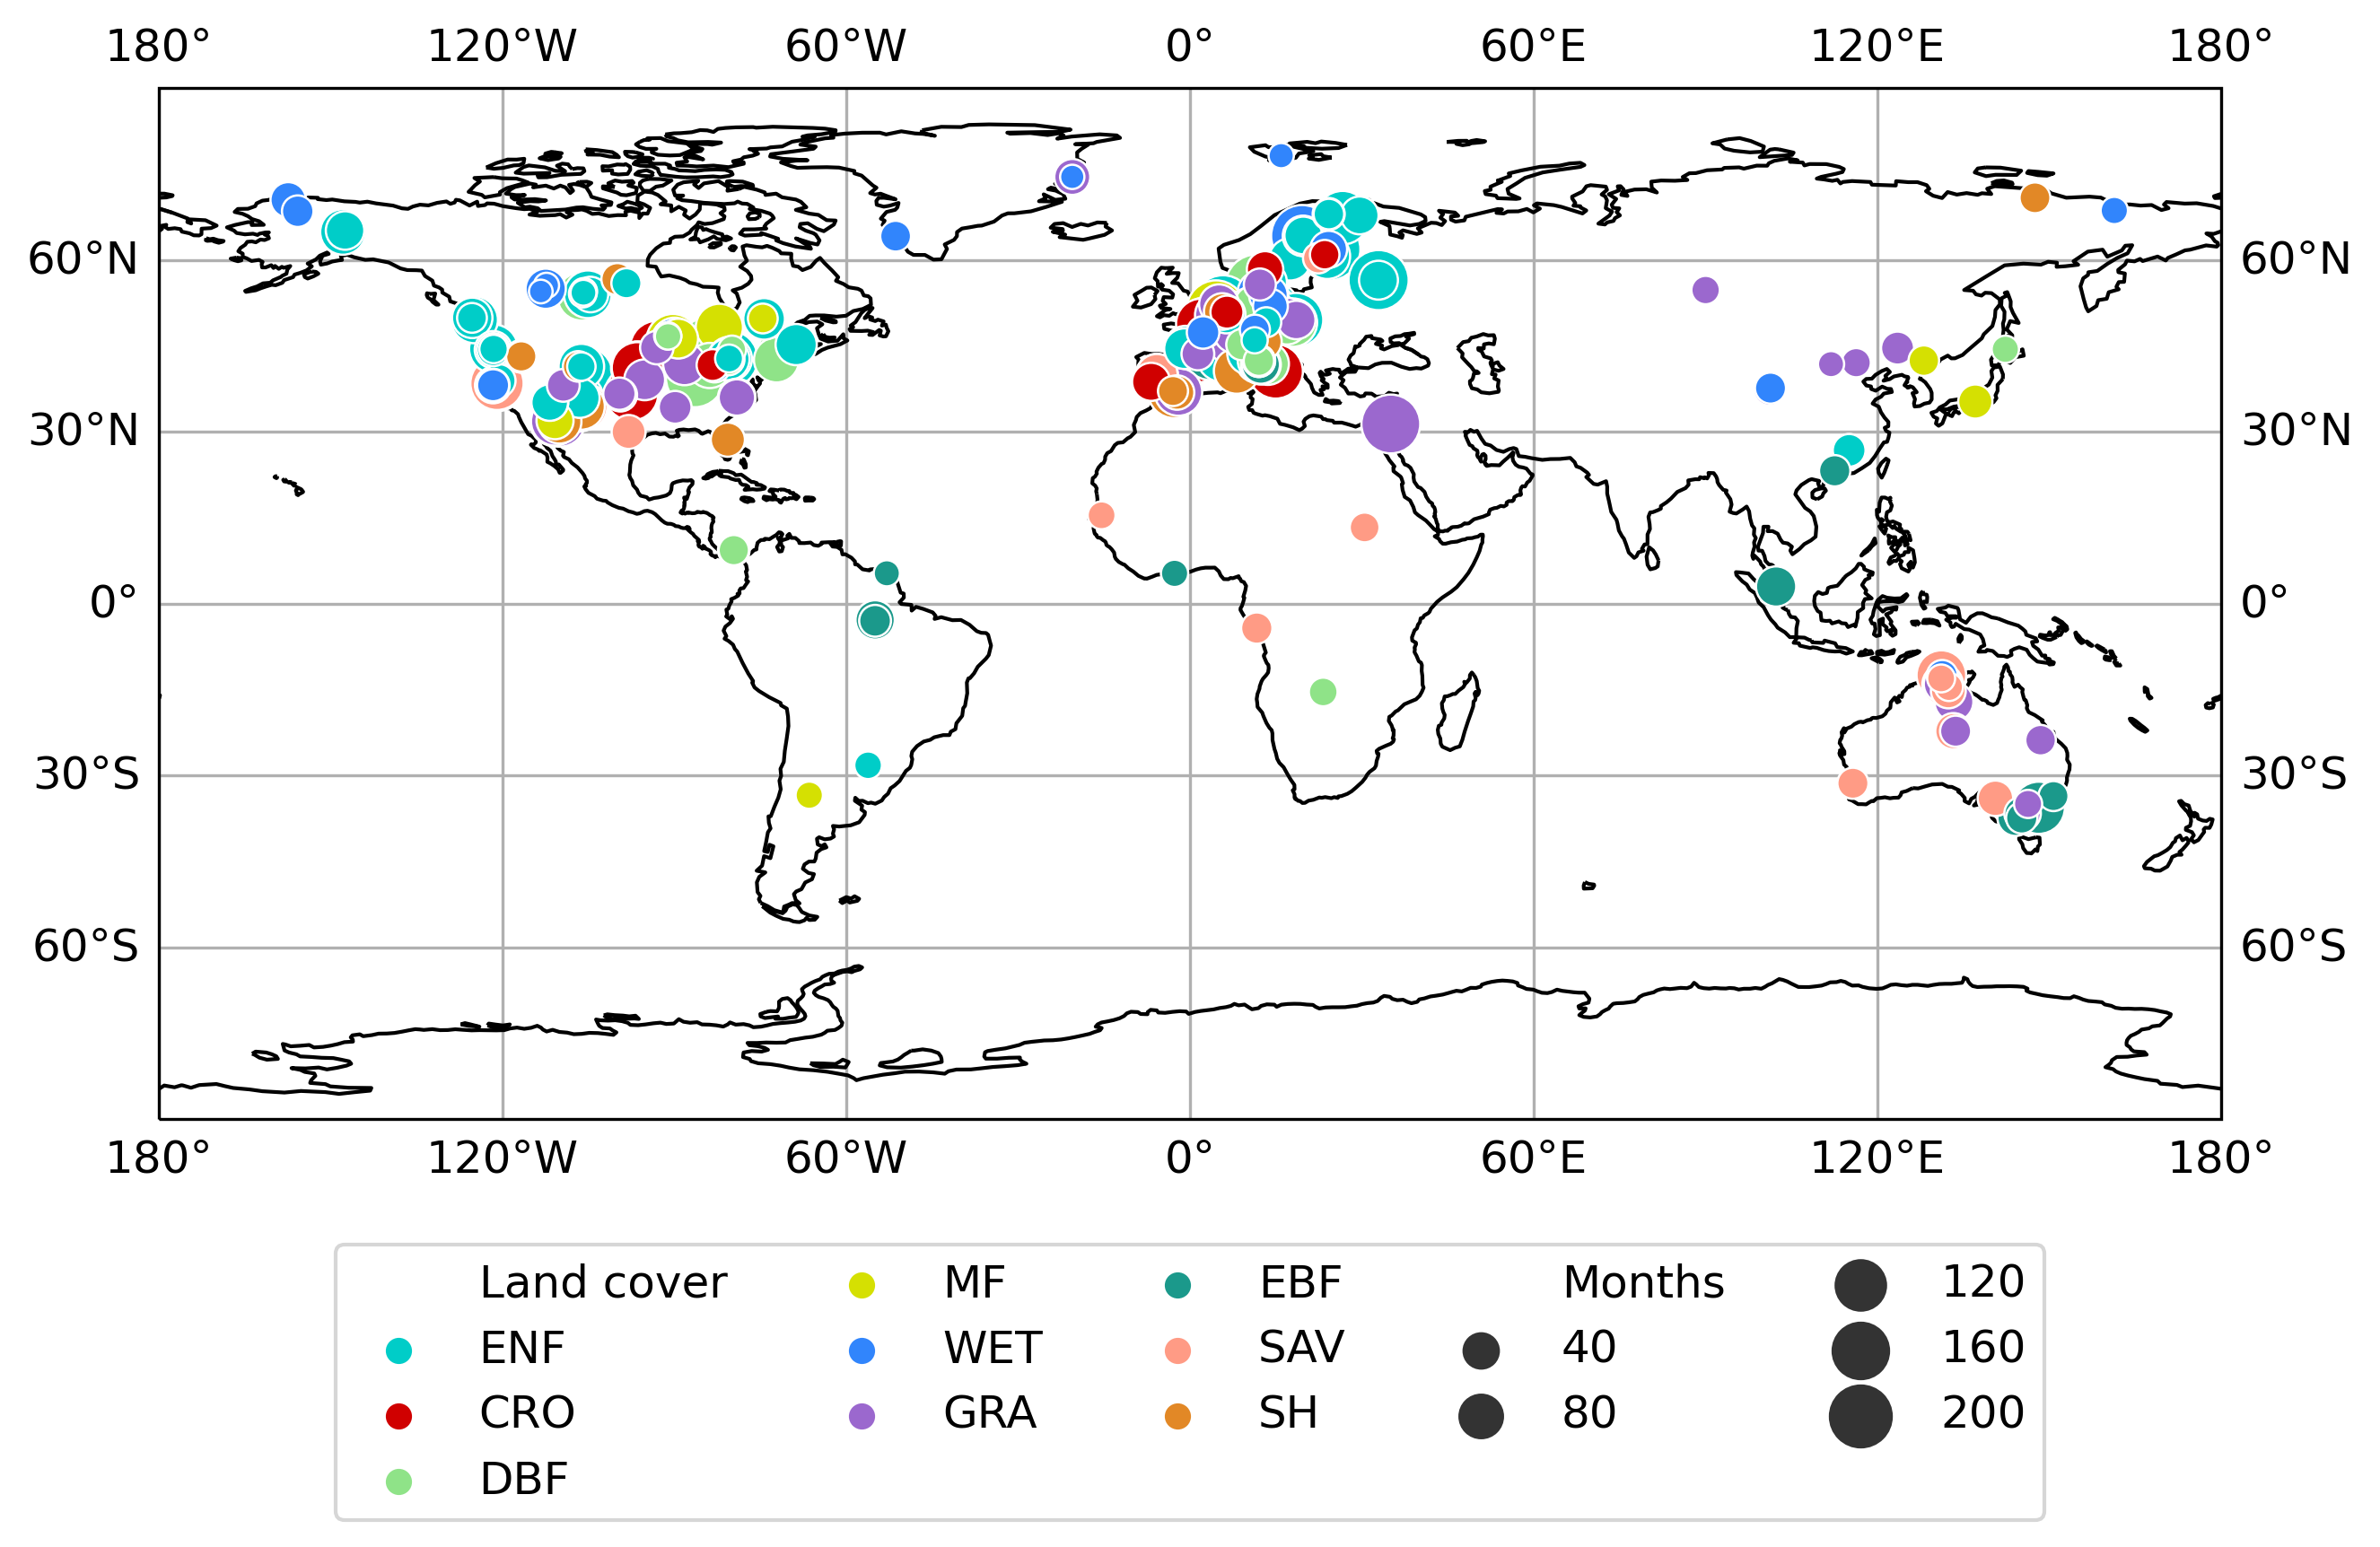

In [10]:
meta_disp = meta.copy()
meta_disp = meta_disp.rename(columns={'IGBP': 'Land cover', 'avail_months': 'Months'}).sort_values('Months', ascending=False)
print(meta_disp.shape)

fig = plt.figure(figsize=(9, 7))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_global()
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, zorder=0)
ax.coastlines(zorder=1)
sns.scatterplot(data=meta_disp, x='LOCATION_LONG', y='LOCATION_LAT', ax=ax, hue='Land cover', size='Months', sizes=(40, 300), edgecolor='#ffffff', palette=lc_colors)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncols=5)
plt.tight_layout()
plt.savefig('analysis/eda/locations_map.pdf')

### LC distribution

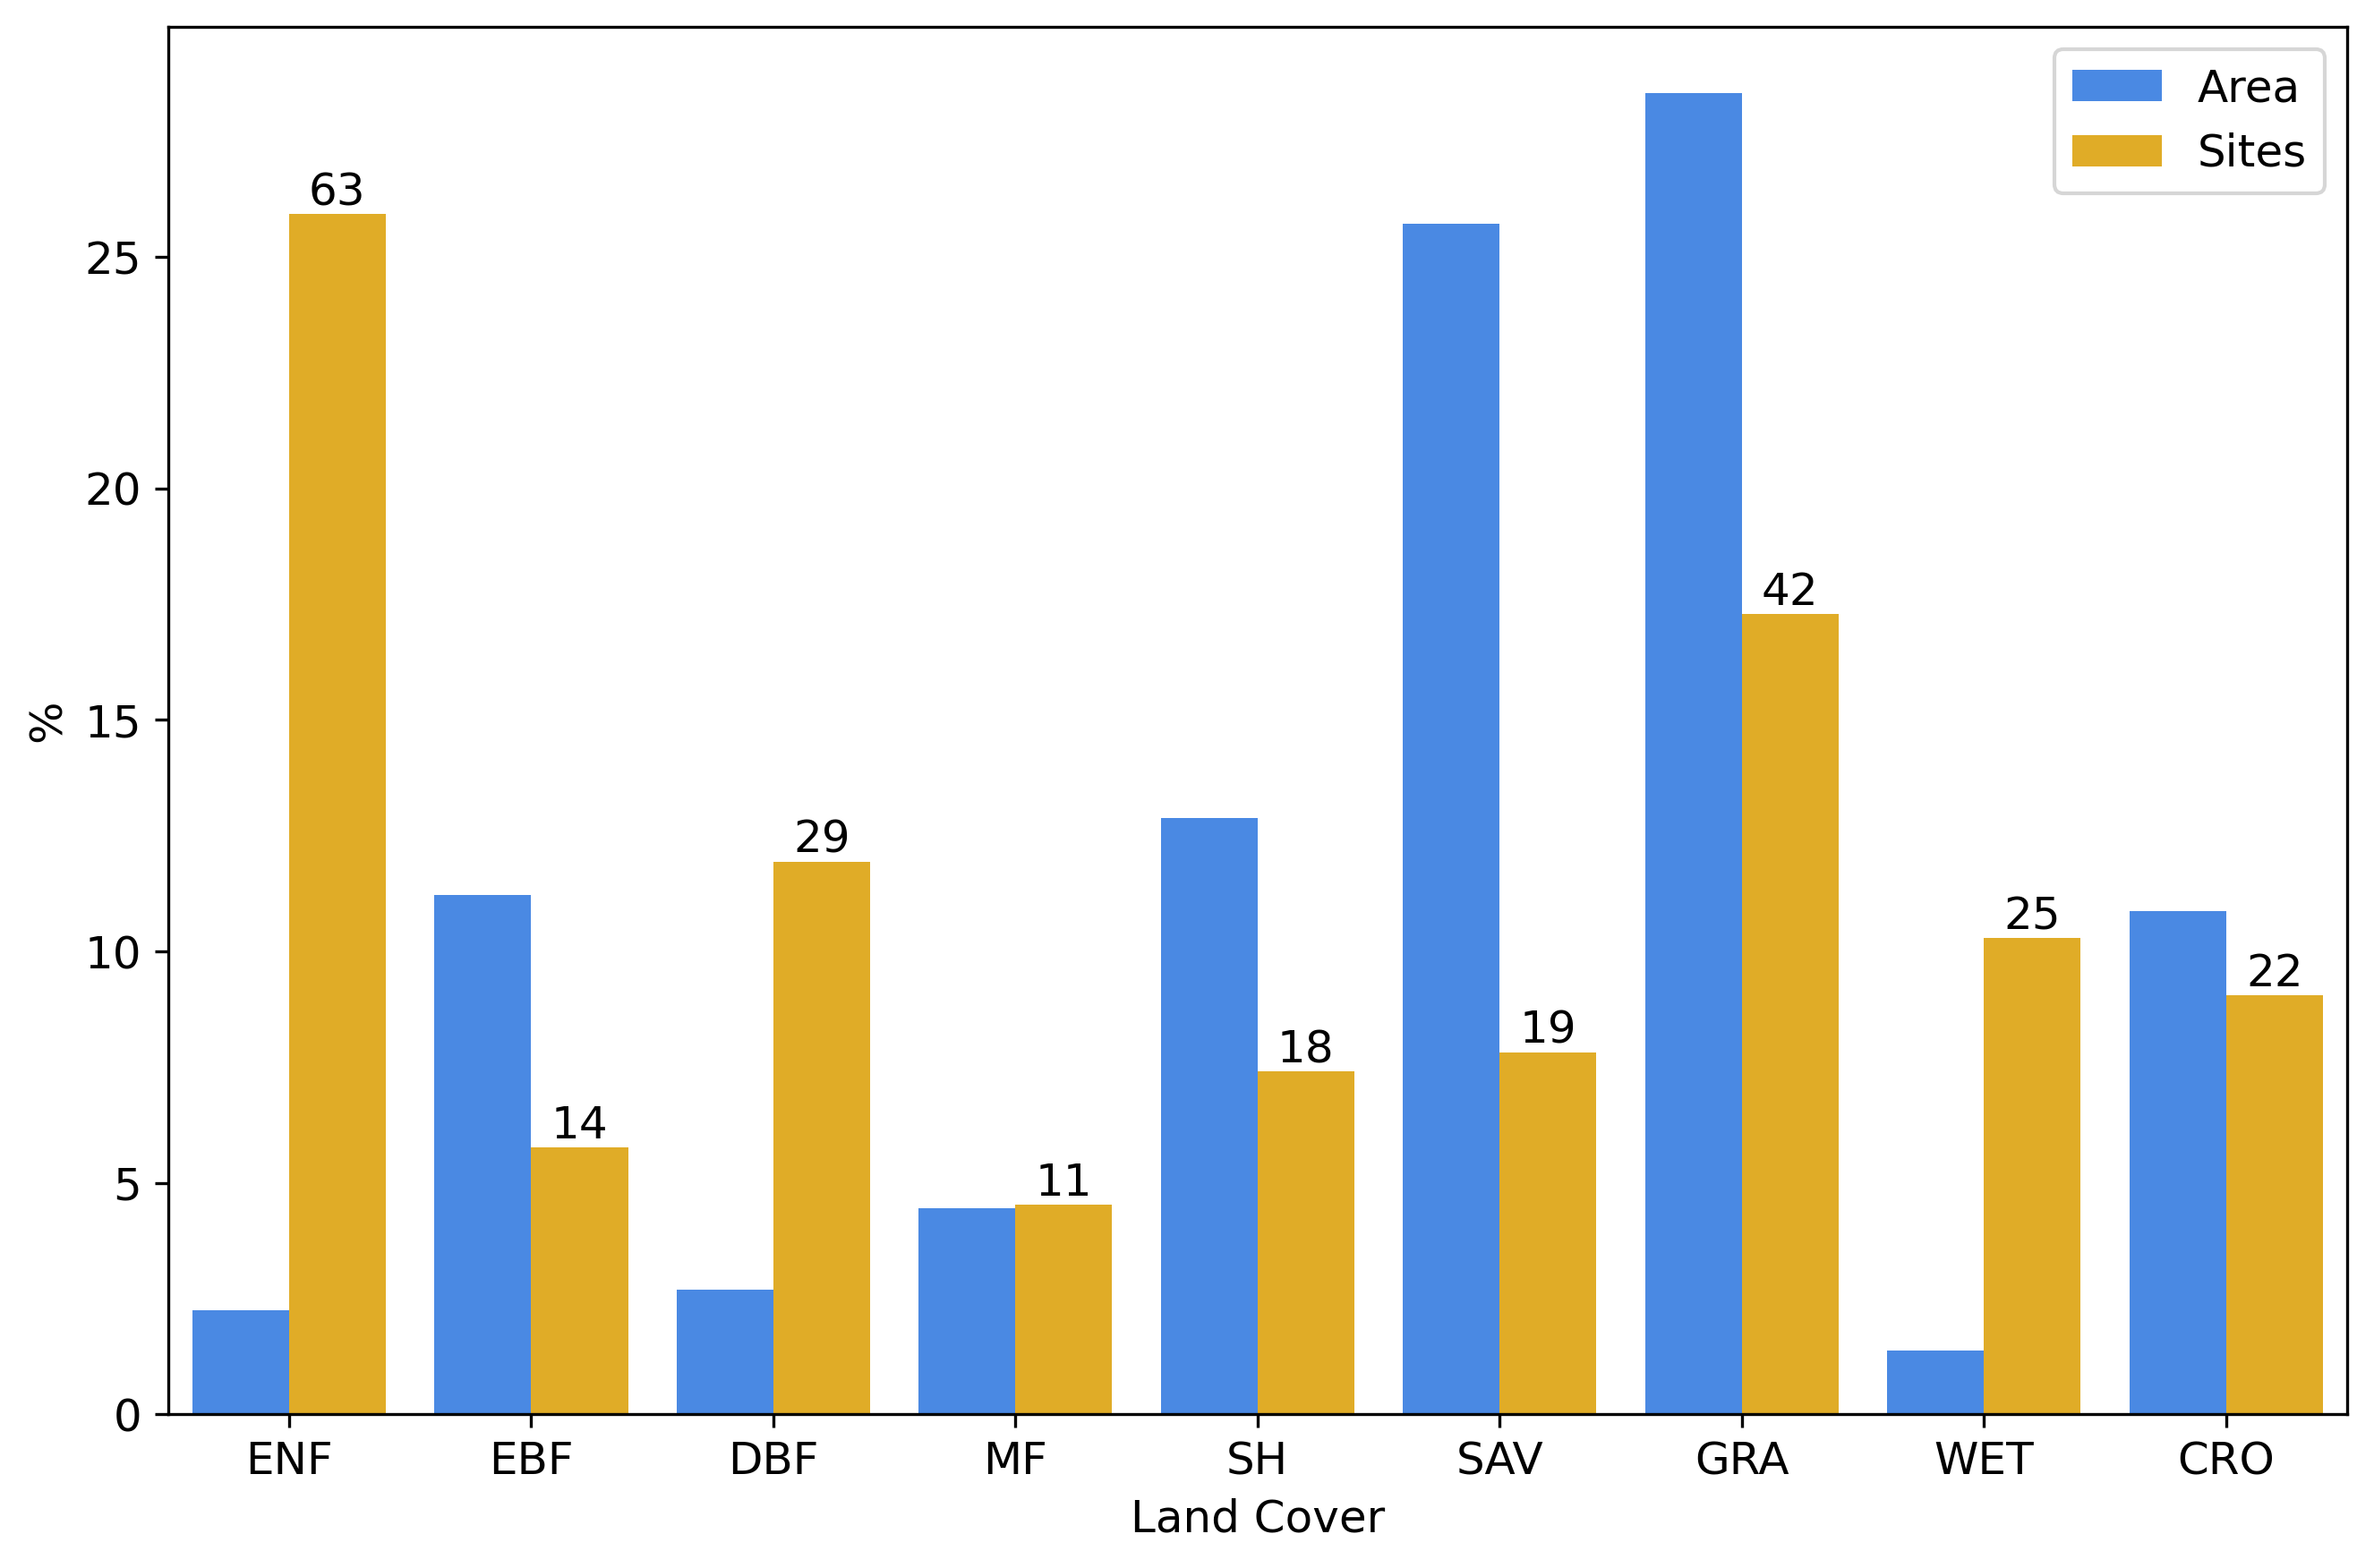

In [5]:
# LC distribution worldwide
lc_area = {
    'IGBP': ['ENF', 'EBF', 'DBF', 'MF', 'SH', 'SAV', 'GRA', 'WET', 'CRO'], #, 'SNO', 'BAR', 'Other'
    'Area': [2411991, 12052970, 2898066, 4786627, 13841035, 27642838, 30682224, 1475918, 11685607] #, 14840052, 20226109, 2637722
}
lc_area = pd.DataFrame(lc_area).set_index('IGBP')
lc_area = pd.concat([lc_area, meta.groupby('IGBP')['LOCATION_LONG'].count()], axis=1)
lc_area = lc_area.rename(columns={'LOCATION_LONG': 'Sites'})
lc_area_perc = lc_area*100 / lc_area.sum(axis=0)
lc_area_perc = lc_area_perc.stack().reset_index()
lc_area_perc.columns = ['Land Cover', 'Type', '%']

ax = sns.barplot(data=lc_area_perc, x='Land Cover', y='%', hue='Type')
ax.bar_label(ax.containers[1], lc_area['Sites'].values.astype(int))

plt.legend(loc='upper right', title='')
plt.tight_layout()
plt.savefig('analysis/eda/lc_distribution.pdf')

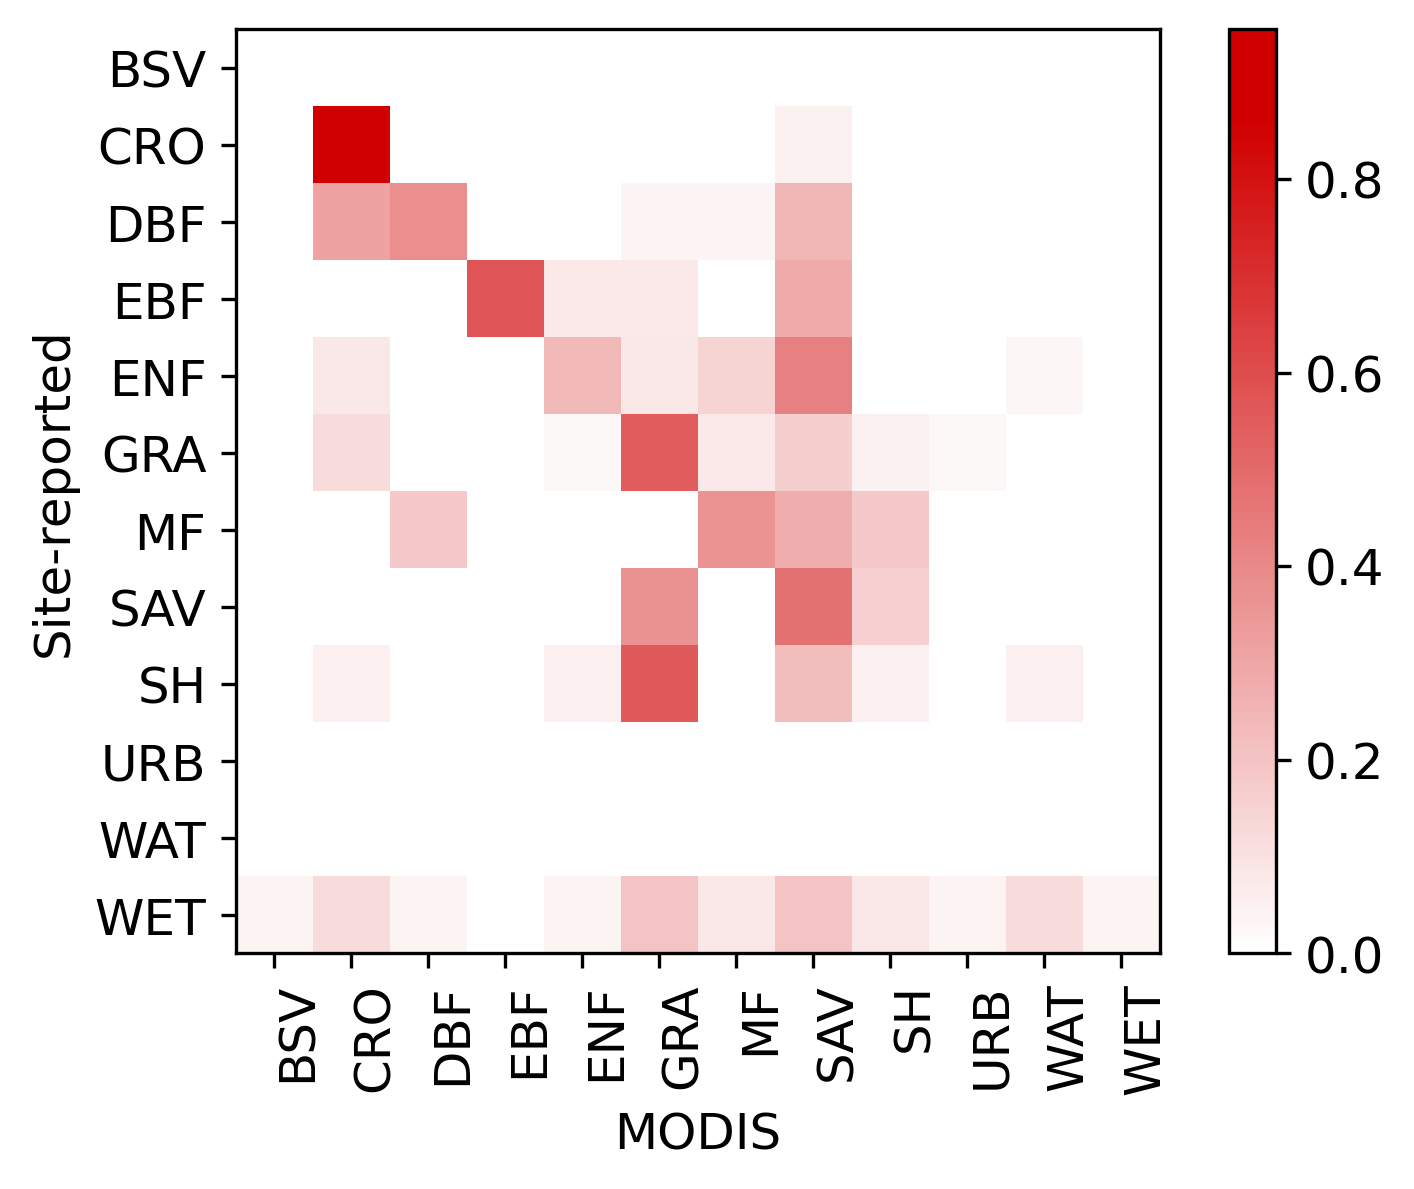

In [23]:
# create a confusion matrix between MODIS_LC and IGBP
lc_comp = pd.concat([meta['IGBP'], data.groupby('SITE_ID').tail(1)['MODIS_LC'].droplevel('Date')], axis=1) 
categories = sorted(set(lc_comp['IGBP']) | set(lc_comp['MODIS_LC']))
                    
cm = confusion_matrix(lc_comp['IGBP'], lc_comp['MODIS_LC'], labels=categories, normalize='true')

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(cm, interpolation='nearest', cmap=analysis.cmap_gpp_3)
ax.figure.colorbar(im, ax=ax)

# Set labels, title, and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=categories, yticklabels=categories,
       ylabel='Site-reported',
       xlabel='MODIS')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Display the confusion matrix
plt.savefig('analysis/eda/lc_confusion.pdf')